<a href="https://colab.research.google.com/github/nickberezny/UnifiedInteractionControl/blob/main/singleDOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="slider" type="slide" limited="true" axis="1 0 0" range="-.6 .6" pos="-.2 -.2 -.2" stiffness="40" springref="0" damping="10"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    </body>
  </worldbody>
  <actuator>
    <general ctrllimited="false" joint="slider"/>
 </actuator>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

""

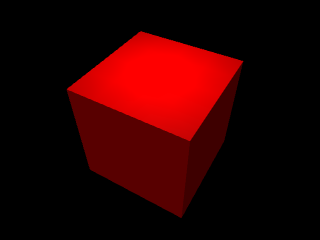

In [ ]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [ ]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 60  # (seconds)
framerate = 60  # (Hz)

n_steps = int(duration / model.opt.timestep)
position = np.zeros(n_steps)
force = np.zeros(n_steps)
sim_time = np.zeros(n_steps)

# Simulate and display video.
frames = []
i = 0
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    #mujoco.mj_applyFT(model, data, [500,500,500], [1,1,1], [1,1,1],  model.geom('red_box').id, data.qfrc_applied)
    #mujoco.mj_applyFT(model,data,force,torque,point, model.geom('red_box').id, data.qfrc_applied)
    data.ctrl = -10
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)
      position[i] = data.qpos
      force[i] = 40*(data.qpos) + 10*(data.qvel)
      sim_time[i] = data.time
      i = i + 1


media.show_video(frames, fps=framerate)



<ipython-input-91-9e36942b3897>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position[i] = data.qpos
<ipython-input-91-9e36942b3897>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  force[i] = 40*(data.qpos) + 10*(data.qvel)


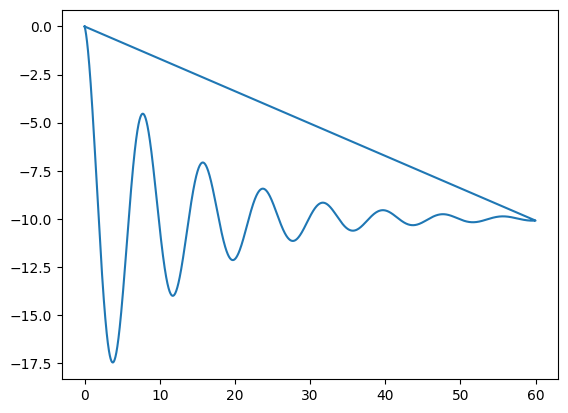

In [ ]:
# plot
_, ax = plt.subplots(1, 1)
ax.plot(sim_time, force)

In [ ]:
n_steps
force[3500]

np.float64(-10.04440694116422)